# 5 - Fold CV

## Prepare

### Information Summary

`DataSet12CV` is the working data set for the 5-folder CV

### Step 1. Convert TIFF to the final folder and Copy JPG into final folder

In [155]:
from shutil import copy
from skimage import io

# import *=all the models from torchvision
from fastai.vision import *
from torchvision.models import *
from sklearn.metrics import roc_curve, auc

import os
import glob
import numpy
import errno
import pandas as pd
os.getcwd()

'/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet12CV/NonBleedingFinal'

In [12]:
# Some helping functions
def createFolder ( folderName ) :
	"""
	Safely create folder when needed
	Parameters
	----------
	folderName : the directory that you  want to safely create
	Returns
	-------
	None
	"""
	if not os.path.exists ( folderName ) :
		try :
			os.makedirs ( folderName )
		except OSError as exc :  # Guard against race condition
			if exc.errno != errno.EEXIST :
				raise

In [1]:
# golbal info
working_folder = "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet12CV/"

In [17]:
# Bleeding Cases
sourceFolder = working_folder + 'Bleeding'
destnationFolder = working_folder + 'BleedingFinal'
#os.listdir(sourceFolder)
for Patient in os.listdir ( sourceFolder ):
    if Patient != '.DS_Store':
        imgFolder = sourceFolder + '/' + Patient
        # creat results folders
        destImgFolder = destnationFolder + '/' + Patient
        createFolder(destImgFolder)
        os.chdir(imgFolder)
        for file in glob.glob("*.tif"):
            # read in Tiff convert to JPG and copy to final Folder
            img = io.imread ( imgFolder + '/' + file )
            img_new_name = file.split('.')[0] + ".jpg"
            io.imsave (  img_new_name , img , quality = 100 )
            copy ( img_new_name , destImgFolder )
            os.remove(img_new_name)
        # Go Back to sourceFolder
        os.chdir('..')

### Bleeding-JPG can be manually copied into new folder

In [19]:
## Non Bleeding Cases
sourceFolder = working_folder + 'NonBleeding'
destnationFolder = working_folder + 'NonBleedingFinal'
#os.listdir(sourceFolder)
for Patient in os.listdir ( sourceFolder ):
    if Patient != '.DS_Store':
        imgFolder = sourceFolder + '/' + Patient
        # creat results folders
        destImgFolder = destnationFolder + '/' + Patient
        createFolder(destImgFolder)
        os.chdir(imgFolder)
        # Checking there must be 5 TIFF images
        assert len(glob.glob("*.tif")) == 5
        for file in glob.glob("*.tif"):
            # read in Tiff convert to JPG and copy to final Folder
            img = io.imread ( imgFolder + '/' + file )
            img_new_name = file.split('.')[0] + ".jpg"
            io.imsave (  img_new_name , img , quality = 100 )
            copy ( img_new_name , destImgFolder )
            os.remove(img_new_name)
        # Go Back to sourceFolder
        os.chdir('..')

### Checking the data accuracy 

In [24]:
# Bleeding Cases
FinalFolder = working_folder + 'BleedingFinal'
for Patient in os.listdir ( FinalFolder ):
    if Patient != '.DS_Store':
        imgFolder = FinalFolder + '/' + Patient
        os.chdir(imgFolder)
        # Checking there must be 5 TIFF images
        assert len(glob.glob("*.jpg")) == 5
        os.chdir('..')

## Non Bleeding Cases
FinalFolder = working_folder + 'NonBleedingFinal'
for Patient in os.listdir ( FinalFolder ):
    if Patient != '.DS_Store':
        imgFolder = FinalFolder + '/' + Patient
        os.chdir(imgFolder)
        # Checking there must be 5 TIFF images
        assert len(glob.glob("*.jpg")) == 5
        os.chdir('..')

In [25]:
# Pass all the Assertions

## Step 2. Generating 5-folder CV 

### Algorithm Used for generating 5-folder CV (Stratified k-fold cross validation)

So the purpose for generating Stratified k-fold cross validation

### 2.1 Include the same postive patients form PK

['1002' '1003' '1004' '1005' '1006' '1009' '1010' '1011' '1012' '1014'
 '1016' '1017' '1019' '1021' '1024' '1025' '1026' '1027' '1028' '11' '12'
 '15' '17' '18' '19' '1' '20' '24' '25' '33' '35' '37' '38' '39' '40' '42'
 '44' '45' '48' '49' '4' '50' '51' '52' '54' '55' '56' '57' '58' '5' '60'
 '61' '63' '64' '66' '67' '68' '69' '6' '70' '71' '72' '73' '74' '75' '76'
 '77' '78' '7934' '7936' '7948' '80' '81' '82' '83']
 
Not used:

* Patient 22
* Patient 46
* Patient 47
* Patient 59
* Patient 62

Patient 50 - Not in my list of patient

In [169]:
X = list()
y = list()
# Bleeding Cases
FinalFolder = working_folder + 'BleedingFinal'
for Patient in os.listdir ( FinalFolder ):
    if Patient != '.DS_Store':
        X.append(Patient)
        y.append(0)

## Non Bleeding Cases
FinalFolder = working_folder + 'NonBleedingFinal'
for Patient in os.listdir ( FinalFolder ):
    if Patient != '.DS_Store':
        X.append(Patient)
        y.append(1)

In [55]:
# Stratified k-fold cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=1023, shuffle=True)
# variables to hold KFold splitting
train_splited_index_list = list()
test_splited_index_list = list()

# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y):
    print("%d %d"%(len(train_index),len(test_index)))
    train_splited_index_list.append(train_index)
    test_splited_index_list.append(test_index)

101 26
101 26
101 26
102 25
103 24


In [170]:
# Save the X and y into csv file for better reference
with open('StratifiedKFoldRecord.txt','w') as rf:
    for ind,val in enumerate(X):
        rf.write("%d \t %s \t %d \n"%(ind,val,y[ind]))

In [172]:
# Convert the splited index into the training and testing data of Fast AI
workingFolder = "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet12CV/" # fastAI1~5
sourceBleedingFolder = workingFolder + "BleedingFinal"
sourceNonBleedingFolder = workingFolder + "NonBleedingFinal"
# Loop through each fold
for i in range(5):
    print("Now processing %d of Stratified 5 Fold Cross Validation"%(i+1))
    # open the log CSV files
    with open ( "log_NonBleeding_"+str(i+1)+".csv" , 'w' ) as nonbleed_log :
        with open ( "log_Bleeding_"+str(i+1)+".csv" , 'w' ) as bleed_log :
            # init ID for images
            nonbleedingID = 0
            bleedingID = 0
            # Part 1 : Generating Training Images
            destPrefix = workingFolder + 'CV/fastAI' + str(i+1) + '/train/'
            for index in train_splited_index_list[i]:
                className = ''
                sourceFolder = ''
                print("%d \t %d \t %s "%(index,y[index],X[index]))
                if y[index] == 0:
                    destFolder = destPrefix + 'bleeding'
                    className = 'bleeding'
                    sourceFolder = sourceBleedingFolder + '/' + X[index]
                    for file in os.listdir ( sourceFolder ):
                        if file != '.DS_Store':
                            shutil.copy(sourceFolder+'/'+file, destFolder+'/'+className + '.' + str(bleedingID)+'.jpg')
                            bleed_log.write("%s ,%s, %s \n" % (X[index], file, className + '.' + str(bleedingID)+'.jpg' ))
                            bleedingID = bleedingID + 1
                if y[index] == 1: 
                    destFolder = destPrefix + 'nonbleeding'
                    className = 'nonbleeding'
                    sourceFolder = sourceNonBleedingFolder + '/' + X[index]
                    for file in os.listdir ( sourceFolder ):
                        if file != '.DS_Store':
                            shutil.copy(sourceFolder+'/'+file, destFolder+'/'+className + '.' + str(nonbleedingID)+'.jpg')
                            nonbleed_log.write("%s ,%s, %s \n" % (X[index], file, className + '.' + str(nonbleedingID)+'.jpg' ))
                            nonbleedingID = nonbleedingID + 1
                    
            # Part 2 : Generating Testing Images
            destPrefix = workingFolder + 'CV/fastAI' + str(i+1) + '/test/'
            for index in test_splited_index_list[i]:
                className = ''
                sourceFolder = ''
                if y[index] == 0:
                    destFolder = destPrefix + 'bleeding'
                    className = 'bleeding'
                    sourceFolder = sourceBleedingFolder + '/' + X[index]
                    for file in os.listdir ( sourceFolder ):
                        if file != '.DS_Store':
                            shutil.copy(sourceFolder+'/'+file, destFolder+'/'+className + '.' + str(bleedingID)+'.jpg')
                            bleed_log.write("%s ,%s, %s \n" % (X[index], file, className + '.' + str(bleedingID)+'.jpg' ))
                            bleedingID = bleedingID + 1
                if y[index] == 1: 
                    destFolder = destPrefix + 'nonbleeding'
                    className = 'nonbleeding'
                    sourceFolder = sourceNonBleedingFolder + '/' + X[index]
                    for file in os.listdir ( sourceFolder ):
                        if file != '.DS_Store':
                            shutil.copy(sourceFolder+'/'+file, destFolder+'/'+className + '.' + str(nonbleedingID)+'.jpg')
                            nonbleed_log.write("%s ,%s, %s \n" % (X[index], file, className + '.' + str(nonbleedingID)+'.jpg' ))
                            nonbleedingID = nonbleedingID + 1

Now processing 1 of Stratified 5 Fold Cross Validation
0 	 0 	 Patient 1027 
1 	 0 	 Patient 1016 
3 	 0 	 Patient 1011 
4 	 0 	 Patient 37B 
6 	 0 	 Patient 1028 
7 	 0 	 Patient 1017 
8 	 0 	 Patient 1021 
9 	 0 	 Patient 1019 
10 	 0 	 Patient 1026 
11 	 0 	 Patient 45 
12 	 0 	 Patient 42 
15 	 0 	 Patient 73 
16 	 0 	 Patient 18 
17 	 0 	 Patient 20 
19 	 0 	 Patient 72 
20 	 0 	 Patient 75 
21 	 0 	 Patient 81 
22 	 0 	 Patient 44 
23 	 0 	 Patient 17 
24 	 0 	 Patient 6 
25 	 0 	 Patient 19 
26 	 0 	 Patient 1 
28 	 0 	 Patient 66 
30 	 0 	 Patient 68 
31 	 0 	 Patient 57 
32 	 0 	 Patient 33 
33 	 0 	 Patient 51 
35 	 0 	 Patient 56 
36 	 0 	 Patient 60 
37 	 0 	 Patient 58 
38 	 0 	 Patient 67 
39 	 0 	 Patient 1004 
40 	 0 	 Patient 39B 
41 	 0 	 Patient 1003 
42 	 0 	 Patient 1002 
43 	 0 	 Patient 1005 
44 	 0 	 Patient 1024 
46 	 0 	 Patient 38B 
47 	 0 	 Patient 1014 
48 	 0 	 Patient 79_36 
49 	 0 	 Patient 1025 
50 	 0 	 Patient 4 
51 	 0 	 Patient 24 
52 	 0 	 Patient 

In [165]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Checking the Performance of 5 fold CV

The accuracy is 0.607692301273346 %.
ROC area is 0.5728484848484848


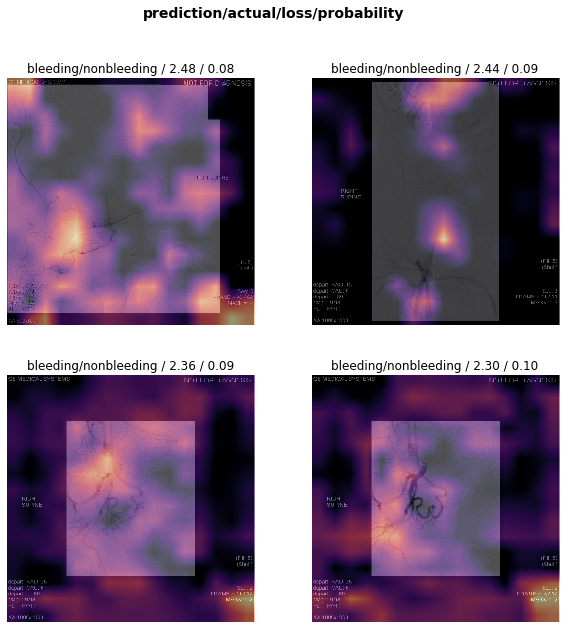

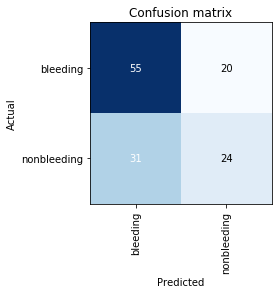

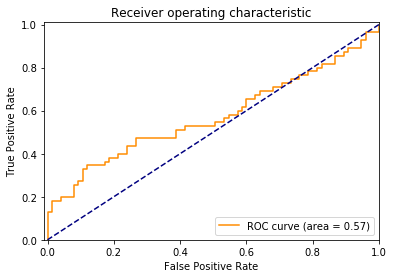

In [174]:
# checking performance for folder 1
currentKFold = 1
path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet12CV/CV/fastAI1/")

tfms = get_transforms(do_flip=False,
                      flip_vert=False,
                      max_lighting=0.0,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)

# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data_test = ImageDataBunch.from_folder(path,
                                  train='train',
                                  valid='test',
                                  ds_tfms= tfms,
                                  size=512).normalize()

print(data_test)

# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/resultsModelWeight/stage3/CV/res152-folder1")
learner152.validate(data_test.valid_dl)
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(4, figsize=(10,10))
tmpfig=interp.plot_confusion_matrix(return_fig=True)
tmpfig.savefig('confusion'+ str(currentKFold) +'.png', dpi=300)

preds,yclass, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, yclass)
print('The accuracy is {0} %.'.format(acc))

# Plot Heat Map
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(yclass, probs, pos_label=1)
# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc'+ str(currentKFold)+'.png', dpi=300)

In [180]:
# Generate Report of Performance
# print(len(data_test.valid_ds.items))
with open("performance-fold"+str( currentKFold )+"-Neg.csv",'w') as perfcsvNeg:
    with open("performance-fold"+str( currentKFold )+"-Pos.csv",'w') as perfcsvPos:
        perfcsvNeg.write("%s,%s,%s\n"%("IMG","Pred","GT"))
        perfcsvPos.write("%s,%s,%s\n"%("IMG","Pred","GT"))
        for i in range(len(data_test.valid_ds.items)):
            # Bleeding
            fnames = data_test.valid_ds.items[i].name.split('.')
            if yclass[i].item() == 0:
                perfcsvPos.write("%s,%d,%d\n"%(data_test.valid_ds.items[i].name,np.argmax(preds[i].numpy()),yclass[i].item()))
            if yclass[i].item() == 1:
                perfcsvNeg.write("%s,%d,%d\n"%(data_test.valid_ds.items[i].name,np.argmax(preds[i].numpy()),yclass[i].item()))

In [181]:
gtBleedingCSV = pd.read_csv("log_Bleeding_"+str( currentKFold )+".csv",header=None,names=['PatientID','oldJPGName','IMG'])
for index, row in gtBleedingCSV.iterrows():
    gtBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
gtBleedingCSV.head()

,PatientID,oldJPGName,IMG
0,Patient 1027,1027_15_15.jpg,bleeding.0.jpg
1,Patient 1027,1027_11_15.jpg,bleeding.1.jpg
2,Patient 1027,1027_10_15.jpg,bleeding.2.jpg
3,Patient 1027,1027_9_15.jpg,bleeding.3.jpg
4,Patient 1027,1027_12_15.jpg,bleeding.4.jpg


In [182]:
predBleedingCSV = pd.read_csv("performance-fold"+str( currentKFold )+"-Pos.csv",header=0)
for index, row in predBleedingCSV.iterrows():
    predBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
predBleedingCSV.head()

,IMG,Pred,GT
0,bleeding.323.jpg,0,0
1,bleeding.337.jpg,0,0
2,bleeding.336.jpg,0,0
3,bleeding.322.jpg,1,0
4,bleeding.295.jpg,0,0


In [183]:
df_final = gtBleedingCSV.merge(predBleedingCSV, on='IMG')
df_final.head()

,PatientID,oldJPGName,IMG,Pred,GT
0,Patient 79_34,79_30_34.jpg,bleeding.295.jpg,0,0
1,Patient 79_34,79_20_34.jpg,bleeding.296.jpg,0,0
2,Patient 79_34,79_27_34.jpg,bleeding.297.jpg,0,0
3,Patient 79_34,79_23_34.jpg,bleeding.298.jpg,0,0
4,Patient 79_34,79_33_34.jpg,bleeding.299.jpg,0,0


In [184]:
# since GT is always 0 for Bleeding cases
# we only need to count all 1 in `df_final` since the 1 is the wrong predictions
A = df_final.groupby('PatientID').sum()
B = df_final.groupby('PatientID').count()

Correct = B.Pred - A.Pred
score = (1.0 * Correct/B.Pred)
# then let's get the correct predictions for the bleeding patients
# B - A is the answer
# merge results and for the final output
B['correct'] = Correct
B['score'] = score 
B.to_csv("BleedingSummaryScores_"+str( currentKFold )+".csv")

In [188]:
# Neg Patients
gtNonBleedingCSV = pd.read_csv("log_NonBleeding_"+str( currentKFold )+".csv",header=None,names=['PatientID','oldJPGName','IMG'])
for index, row in gtNonBleedingCSV.iterrows():
    gtNonBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
gtNonBleedingCSV.head()

,PatientID,oldJPGName,IMG
0,Patient 141,141.36.jpg,nonbleeding.0.jpg
1,Patient 141,141.34.jpg,nonbleeding.1.jpg
2,Patient 141,141.27.jpg,nonbleeding.2.jpg
3,Patient 141,141.29.jpg,nonbleeding.3.jpg
4,Patient 141,141.38.jpg,nonbleeding.4.jpg


In [189]:
predNonBleedingCSV = pd.read_csv("performance-fold"+str( currentKFold )+"-Neg.csv",header=0)
for index, row in predBleedingCSV.iterrows():
    predBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
predNonBleedingCSV.head()

,IMG,Pred,GT
0,nonbleeding.210.jpg,0,1
1,nonbleeding.238.jpg,0,1
2,nonbleeding.239.jpg,0,1
3,nonbleeding.211.jpg,0,1
4,nonbleeding.213.jpg,0,1


In [190]:
df_final = gtNonBleedingCSV.merge(predNonBleedingCSV, on='IMG')
df_final.head()

,PatientID,oldJPGName,IMG,Pred,GT
0,Patient 7,7_28.jpg,nonbleeding.210.jpg,0,1
1,Patient 7,7_30.jpg,nonbleeding.211.jpg,0,1
2,Patient 7,7_32.jpg,nonbleeding.212.jpg,0,1
3,Patient 7,7_26.jpg,nonbleeding.213.jpg,0,1
4,Patient 7,7_34.jpg,nonbleeding.214.jpg,0,1


In [191]:
# since GT is always 0 for Bleeding cases
# we only need to count all 1 in `df_final` since the 1 is the wrong predictions
A = df_final.groupby('PatientID').sum()
B = df_final.groupby('PatientID').count()

Correct = A.Pred
score = (1.0 * Correct/B.Pred)
# then let's get the correct predictions for the bleeding patients
# B - A is the answer
# merge results and for the final output
B['correct'] = Correct
B['score'] = score 
B.to_csv("NonBleedingSummaryScores_"+str( currentKFold )+".csv")

# Loop through other Folds

The accuracy is 0.574999988079071 %.
ROC area is 0.6051428571428571


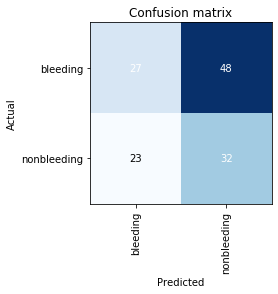

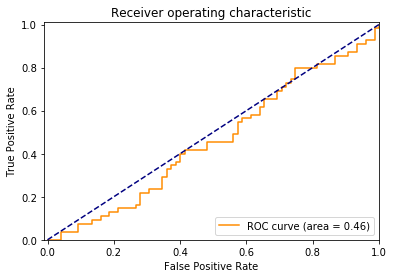

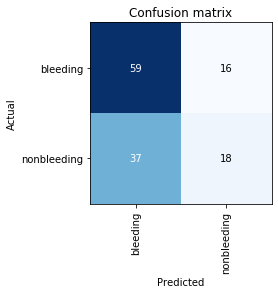

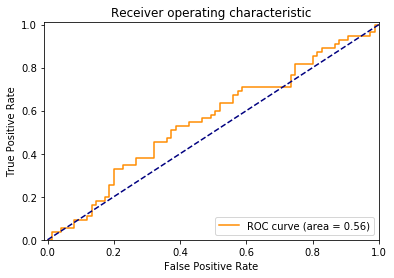

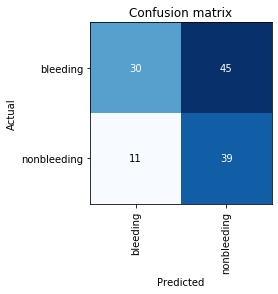

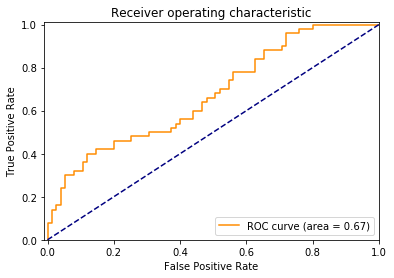

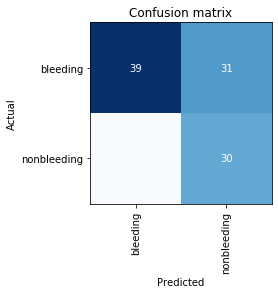

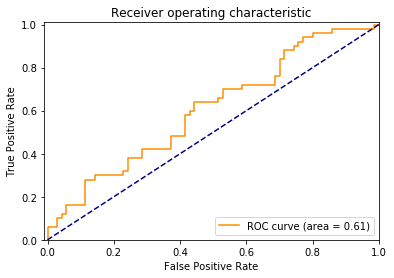

In [192]:
# checking performance for folder 1
for currentKFold in range(2,6):
    path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet12CV/CV/fastAI"+str(currentKFold)+"/")
    tfms = get_transforms(do_flip=False,
                          flip_vert=False,
                          max_lighting=0.0,
                          max_rotate=0.0, 
                          max_zoom=0.0,
                          max_warp=0.0,
                          p_affine=0.0)

    # data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
    data_test = ImageDataBunch.from_folder(path,
                                      train='train',
                                      valid='test',
                                      ds_tfms= tfms,
                                      size=512).normalize()
    # print(data_test)
    # Try to use the ResNet-152 model to test
    # make sure we have the best performing model stage loaded
    learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
    learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/resultsModelWeight/stage3/CV/res152-folder"+str(currentKFold))
    learner152.validate(data_test.valid_dl)
    interp = ClassificationInterpretation.from_learner(learner152)
    #interp.plot_top_losses(4, figsize=(10,10))
    tmpfig=interp.plot_confusion_matrix(return_fig=True)
    tmpfig.savefig('confusion'+ str(currentKFold) +'.png', dpi=300)

    preds,yclass, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
    # get accuracy
    acc = accuracy(preds, yclass)
    print('The accuracy is {0} %.'.format(acc))

    # Plot Heat Map
    # plot_overview(interp, ['nonbleeding','bleeding'])
    # plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(yclass, probs, pos_label=1)
    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area is {0}'.format(roc_auc))
    newfig=plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    newfig.savefig('roc'+ str(currentKFold)+'.png', dpi=300)
    # Generate Report of Performance
    # print(len(data_test.valid_ds.items))
    with open("performance-fold"+str( currentKFold )+"-Neg.csv",'w') as perfcsvNeg:
        with open("performance-fold"+str( currentKFold )+"-Pos.csv",'w') as perfcsvPos:
            perfcsvNeg.write("%s,%s,%s\n"%("IMG","Pred","GT"))
            perfcsvPos.write("%s,%s,%s\n"%("IMG","Pred","GT"))
            for i in range(len(data_test.valid_ds.items)):
                # Bleeding
                fnames = data_test.valid_ds.items[i].name.split('.')
                if yclass[i].item() == 0:
                    perfcsvPos.write("%s,%d,%d\n"%(data_test.valid_ds.items[i].name,np.argmax(preds[i].numpy()),yclass[i].item()))
                if yclass[i].item() == 1:
                    perfcsvNeg.write("%s,%d,%d\n"%(data_test.valid_ds.items[i].name,np.argmax(preds[i].numpy()),yclass[i].item()))
    gtBleedingCSV = pd.read_csv("log_Bleeding_"+str( currentKFold )+".csv",header=None,names=['PatientID','oldJPGName','IMG'])
    for index, row in gtBleedingCSV.iterrows():
        gtBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
    #gtBleedingCSV.head()
    predBleedingCSV = pd.read_csv("performance-fold"+str( currentKFold )+"-Pos.csv",header=0)
    for index, row in predBleedingCSV.iterrows():
        predBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
    #predBleedingCSV.head()
    df_final = gtBleedingCSV.merge(predBleedingCSV, on='IMG')
    df_final.head()
    # since GT is always 0 for Bleeding cases
    # we only need to count all 1 in `df_final` since the 1 is the wrong predictions
    A = df_final.groupby('PatientID').sum()
    B = df_final.groupby('PatientID').count()
    Correct = B.Pred - A.Pred
    score = (1.0 * Correct/B.Pred)
    # then let's get the correct predictions for the bleeding patients
    # B - A is the answer
    # merge results and for the final output
    B['correct'] = Correct
    B['score'] = score 
    B.to_csv("BleedingSummaryScores_"+str( currentKFold )+".csv")
    # Neg Patients
    gtNonBleedingCSV = pd.read_csv("log_NonBleeding_"+str( currentKFold )+".csv",header=None,names=['PatientID','oldJPGName','IMG'])
    for index, row in gtNonBleedingCSV.iterrows():
        gtNonBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
    gtNonBleedingCSV.head()
    predNonBleedingCSV = pd.read_csv("performance-fold"+str( currentKFold )+"-Neg.csv",header=0)
    for index, row in predBleedingCSV.iterrows():
        predBleedingCSV.loc[index,'IMG'] = row['IMG'].strip()
    predNonBleedingCSV.head()
    df_final = gtNonBleedingCSV.merge(predNonBleedingCSV, on='IMG')
    df_final.head()
    # since GT is always 0 for Bleeding cases
    # we only need to count all 1 in `df_final` since the 1 is the wrong predictions
    A = df_final.groupby('PatientID').sum()
    B = df_final.groupby('PatientID').count()
    Correct = A.Pred
    score = (1.0 * Correct/B.Pred)
    # then let's get the correct predictions for the bleeding patients
    # B - A is the answer
    # merge results and for the final output
    B['correct'] = Correct
    B['score'] = score 
    B.to_csv("NonBleedingSummaryScores_"+str( currentKFold )+".csv")

# The End

In [111]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

import gc

from gradcam import GradCam

ImportError: cannot import name 'GradCam'

In [110]:
img = data_test.valid_ds[0]
type(learner152)

gc.collect()
gcam = GradCam.from_one_img(learner152,img)
gcam.plot()

NameError: name 'GradCam' is not defined

In [98]:
data_test.valid_ds[0]

(Image (3, 512, 512), Category bleeding)

#  Patient Level

,IMG,ID,Pred,GT
0,bleeding.2.jpg,2,1,0
1,bleeding.70.jpg,70,1,0
2,bleeding.64.jpg,64,1,0
3,bleeding.58.jpg,58,1,0
4,bleeding.109.jpg,109,0,0


## Read the Excel File and Get the report of Bleeding Classifers

In [4]:
summaryXLSX = pd.read_excel("AnalysisPatientBased/BleedingSummary.xlsx",header=1)

In [13]:
A = summaryXLSX.groupby('patientID').sum()

In [14]:
B = summaryXLSX.groupby('patientID').count()

In [11]:
summaryXLSX.head()

,imgID,patientID,label,Pred,GT,Score,oldfilename,newfileName,IMG,ID
0,1,Patient 1027,Bleeding,1,0,False,1027_10_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.1.jpg,a001
1,2,Patient 1027,Bleeding,1,0,False,1027_12_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.2.jpg,a002
2,3,Patient 1027,Bleeding,1,0,False,1027_9_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.3.jpg,a003
3,4,Patient 1027,Bleeding,1,0,False,1027_11_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.4.jpg,a004
4,5,Patient 1027,Bleeding,0,0,True,1027_8_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.5.jpg,a005


In [26]:
C = pd.concat([A,B['Score']], axis=1)

In [27]:
C

,imgID,Pred,GT,Score,Score
patientID,,,,,
Patient 1002,669,0,0,6.0,6
Patient 1003,936,0,0,9.0,9
Patient 1004,1295,0,0,14.0,14
Patient 1005,948,0,0,8.0,8
Patient 1006,3724,0,0,19.0,19
Patient 1009,1638,0,0,9.0,9
Patient 1010,325,0,0,10.0,10
Patient 1011,242,11,0,0.0,11
Patient 1012,2533,0,0,17.0,17


# Check Non Bleeding Patients

In [31]:
mergedCSV = pd.read_csv("AnalysisPatientBased/NonBleedingSummaryMerged.csv",header=0)

In [32]:
mergedCSV.head()

,imgID,patientID,seriesID,Pred,GT,Score,label,oldfilename,newfileName,IMG,ID
0,1,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_10_25.jpg,nonbleeding.1.jpg,nonbleeding.1.jpg,a001
1,2,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_9_25.jpg,nonbleeding.2.jpg,nonbleeding.2.jpg,a002
2,3,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_18_25.jpg,nonbleeding.3.jpg,nonbleeding.3.jpg,a003
3,4,Patient 1018,Series 4,0,1,False,nonBleeding,B1018_14_25.jpg,nonbleeding.4.jpg,nonbleeding.4.jpg,a004
4,5,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_11_25.jpg,nonbleeding.5.jpg,nonbleeding.5.jpg,a005


In [35]:
A = mergedCSV.groupby(['patientID','seriesID']).sum()

In [38]:
A

imgID  Pred  GT  Score
patientID    seriesID                          
Patient 1001 Series 1     9008     0  32    0.0
             Series 2     8910     0  36    0.0
             Series 3     6034     0  28    0.0
Patient 1008 Series 1     3465     0  18    0.0
             Series 4     1785     0  10    0.0
Patient 1013 Series 1     2490    15  15   15.0
             Series 8      626     4   4    4.0
Patient 1015 Series 1     2205     0  15    0.0
Patient 1018 Series 2      172     0   8    0.0
             Series 3      117     0   9    0.0
             Series 4       36     6   8    6.0
             Series 8      305     7  10    7.0
Patient 1020 Series 1     1972     0  17    0.0
             Series 10    1065     0  15    0.0
             Series 2      791     0  14    0.0
             Series 20     595     0  14    0.0
             Series 9     2697    29  29   29.0
Patient 1023 Sequence 1    952     0   7    0.0
             Sequence 5   1028     0   8    0.0

In [37]:
B = mergedCSV.groupby(['patientID','seriesID']).count()

In [39]:
B

imgID  Pred  GT  Score  label  oldfilename  \
patientID    seriesID                                                 
Patient 1001 Series 1       32    32  32     32     32           32   
             Series 2       36    36  36     36     36           36   
             Series 3       28    28  28     28     28           28   
Patient 1008 Series 1       18    18  18     18     18           18   
             Series 4       10    10  10     10     10           10   
Patient 1013 Series 1       15    15  15     15     15           15   
             Series 8        4     4   4      4      4            4   
Patient 1015 Series 1       15    15  15     15     15           15   
Patient 1018 Series 2        8     8   8      8      8            8   
             Series 3        9     9   9      9      9            9   
             Series 4        8     8   8      8      8            8   
             Series 8       10    10  10     10     10           10   
Patient 1020 Series 1       17    17  17     17     17           17   
             Series 10      15    15  15     15     15           15   
             Series 2       14    14  14     14     14           14   
             Series 20      14    14  14     14     14           14   
             Series 9       29    29  29     29     29           29   
Patient 1023 Sequence 1      7     7   7      7      7            7   
             Sequence 5      8     8   8      8      8            8   

                         newfileName   IMG  ID  
patientID    seriesID                           
Patient 1001 Series 1              32   32  32  
             Series 2              36   36  36  
             Series 3              28   28  28  
Patient 1008 Series 1              18   18  18  
             Series 4              10   10  10  
Patient 1013 Series 1              15   15  15  
             Series 8               4    4   4  
Patient 1015 Series 1              15   15  15  
Patient 1018 Series 2               8    8   8  
             Series 3               9    9   9  
             Series 4               8    8   8  
             Series 8              10   10  10  
Patient 1020 Series 1              17   17  17  
             Series 10             15   15  15  
             Series 2              14   14  14  
             Series 20             14   14  14  
             Series 9              29   29  29  
Patient 1023 Sequence 1             7    7   7  
             Sequence 5             8    8   8

In [40]:
C = pd.concat([A,B['Score']], axis=1)

In [41]:
C

imgID  Pred  GT  Score  Score
patientID    seriesID                                 
Patient 1001 Series 1     9008     0  32    0.0     32
             Series 2     8910     0  36    0.0     36
             Series 3     6034     0  28    0.0     28
Patient 1008 Series 1     3465     0  18    0.0     18
             Series 4     1785     0  10    0.0     10
Patient 1013 Series 1     2490    15  15   15.0     15
             Series 8      626     4   4    4.0      4
Patient 1015 Series 1     2205     0  15    0.0     15
Patient 1018 Series 2      172     0   8    0.0      8
             Series 3      117     0   9    0.0      9
             Series 4       36     6   8    6.0      8
             Series 8      305     7  10    7.0     10
Patient 1020 Series 1     1972     0  17    0.0     17
             Series 10    1065     0  15    0.0     15
             Series 2      791     0  14    0.0     14
             Series 20     595     0  14    0.0     14
             Series 9     2697    29  29   29.0     29
Patient 1023 Sequence 1    952     0   7    0.0      7
             Sequence 5   1028     0   8    0.0      8